In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
def one_hot_encode_smiles(smiles, charset, max_length=120):
    char_to_int = dict((c, i) for i, c in enumerate(charset))
    integer_encoded = [char_to_int[char] for char in smiles]
    if len(integer_encoded) > max_length:
        integer_encoded = integer_encoded[:max_length]
    else:
        integer_encoded = integer_encoded + [0] * (max_length - len(integer_encoded))
    onehot_encoded = np.zeros((max_length, len(charset)), dtype=np.float32)
    for i, val in enumerate(integer_encoded):
        onehot_encoded[i, val] = 1.0

    return onehot_encoded

In [3]:
def decode_smiles_from_one_hot(one_hot_encoded, charset):
    int_to_char = {i: c for i, c in enumerate(charset)}
    integer_decoded = np.argmax(one_hot_encoded, axis=1)
    chars = [int_to_char[idx] for idx in integer_decoded]
    smiles = "".join(chars).rstrip()

    return smiles

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data


class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(90, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 35)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

In [21]:
model = MolecularVAE()
checkpoint = torch.load("/content/drive/MyDrive/checkpoints/checkpoint_epoch_60.pt")
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
df = pd.read_csv("250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].str.rstrip("\n")

In [23]:
charset = set("".join(df["smiles"].values.tolist()))
charset = sorted(list(charset))
charset.insert(0, " ")

In [24]:
len(charset)

35

In [25]:
sampled = df.sample(2000)
batch_size = 128
results = []

for i in range(0, len(sampled), batch_size):
    batch = sampled.iloc[i : i + batch_size]

    encoded_batch = [
        one_hot_encode_smiles(smiles, charset) for smiles in batch["smiles"]
    ]
    encoded_tensor = torch.tensor(encoded_batch).to(device)

    with torch.no_grad():
        output, mean, logvar = model(encoded_tensor)

    output_smiles = [
        decode_smiles_from_one_hot(out.cpu().numpy(), charset) for out in output
    ]

    batch_results = pd.DataFrame(
        {
            "generated_smiles": output_smiles,
            **{f"mean_{i}": mean.cpu().numpy()[:, i] for i in range(mean.shape[1])},
            **{
                f"logvar_{i}": logvar.cpu().numpy()[:, i]
                for i in range(logvar.shape[1])
            },
        },
        index=batch.index,
    )

    results.append(batch_results)

result = pd.concat(results)
sampled = pd.concat([sampled, result], axis=1)

In [26]:
from sklearn.decomposition import PCA

X = sampled.loc[:, sampled.columns.str.startswith("mean")]
n_components = 10
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

In [27]:
y = sampled["logP"]

In [28]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
y_std = sc.fit_transform(y.values.reshape(-1, 1))

In [29]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

kernel = 1.0 * RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0)

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_std, random_state=42, train_size=0.8
)

In [31]:
gpr.fit(X_train, y_train)

GaussianProcessRegressor(alpha=0,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1))

In [32]:
y_pred_train_mean, y_pred_train_std = gpr.predict(X_train, return_std=True)
y_pred_test_mean, y_pred_test_std = gpr.predict(X_test, return_std=True)

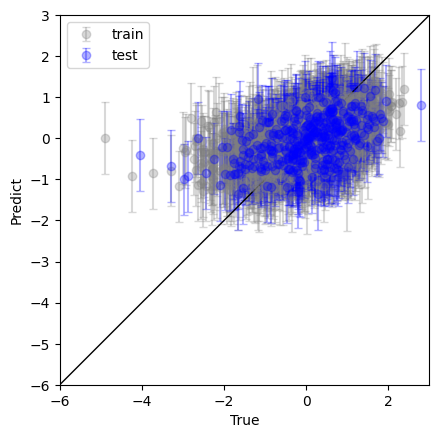

In [33]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(
    y_train,
    y_pred_train_mean,
    yerr=y_pred_train_std,
    linestyle="None",
    capsize=3,
    marker="o",
    color="gray",
    alpha=0.3,
    label="train",
)
ax.errorbar(
    y_test,
    y_pred_test_mean,
    yerr=y_pred_test_std,
    linestyle="None",
    capsize=3,
    marker="o",
    color="blue",
    alpha=0.3,
    label="test",
)
ax.plot([-6, 3], [-6, 3], color="black", linewidth=1.0)
ax.legend()
ax.set_xlim(-6, 3)
ax.set_ylim(-6, 3)
ax.set_xlabel("True")
ax.set_ylabel("Predict")
ax.set_aspect("equal")

In [34]:
n_iter = 10
n_sample_batch = 10
for i in range(n_iter):
    X_pca_cand = np.zeros((n_components, n_sample_batch))
    for j in range(n_components):
        X_pca_cand[:, j] = np.random.uniform(
            X_train[:, j].min(), X_train[:, j].max(), n_sample_batch
        )
    y_cand_pred_mean, y_cand_pred_std = gpr.predict(X_pca_cand, return_std=True)

In [35]:
from scipy.stats import norm


def expected_improvement(y_mean, y_std, y_best, direction, xi=0.01):
    with np.errstate(divide="warn"):
        if direction == "maximize":
            imp = y_mean - y_best - xi
        elif direction == "minimize":
            imp = y_best - y_mean - xi

        Z = imp / y_std
        ei = imp * norm.cdf(Z) + y_std * norm.pdf(Z)
        ei[y_std == 0.0] = 0.0

    return ei

In [36]:
y_cand_ei = expected_improvement(
    y_cand_pred_mean, y_cand_pred_std, y_train.min(), direction="minimize"
)

In [37]:
y_cand_ei

array([9.81080372e-10, 6.14758934e-08, 1.68689765e-10, 2.09628552e-08,
       6.46091670e-10, 1.99028030e-07, 3.51454109e-13, 3.04897106e-10,
       7.12441421e-10, 4.26412859e-12])

In [38]:
y_cand_pred_mean

array([ 0.1459613 , -0.30227379,  0.49834702, -0.36574886,  0.44405018,
       -0.81451307,  1.21371814,  0.63144782,  0.12398622,  1.19019311])

In [56]:
X_exp = X_pca[:50].copy()
y_exp = y_std[:50].copy()
result = {}
n_iter = 50
n_sample_batch = 20

for i in range(1, n_iter + 1):
    gpr.fit(X_exp, y_exp)
    X_pca_cand = np.zeros((n_sample_batch, n_components))
    for j in range(n_components):
        X_pca_cand[:, j] = np.random.uniform(
            X_pca[:, j].min(), X_pca[:, j].max(), n_sample_batch
        )
    y_cand_pred_mean, y_cand_pred_std = gpr.predict(X_pca_cand, return_std=True)
    y_cand_ei = expected_improvement(
        y_cand_pred_mean, y_cand_pred_std, y.min(), direction="minimize"
    )
    top_3_indices = np.argsort(y_cand_ei)[-3:][::-1]
    X_top_3 = X_pca_cand[top_3_indices]
    y_top_3 = y_cand_pred_mean[top_3_indices]

    X_exp = np.vstack((X_exp, X_top_3))
    y_exp = np.append(y_exp, y_top_3)

    result[i] = {
        "mean": y_cand_pred_mean,
        "std": y_cand_pred_std,
        "ei": y_cand_ei,
        "X_exp": X_exp.copy(),
        "y_exp": y_exp.copy(),
        "y_top_3": y_top_3.copy(),
        "X_top_3": X_top_3.copy(),
    }
    if i % 10 == 0:
        print(f"Batch {i}: {y_exp.min()},{y_exp.mean()}, {y_exp.max()}")

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Batch 10: -1.2691083085844632,0.06987351307593193, 1.7615743589336215
Batch 20: -1.2691083085844632,0.03391386815056023, 1.7615743589336215


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Batch 30: -1.2691083085844632,0.016330431540280153, 1.7615743589336215
Batch 40: -1.2691083085844632,0.007530739643300285, 1.7615743589336215
Batch 50: -1.2691083085844632,0.0019706808149720857, 1.7615743589336215


Text(0, 0.5, 'LogP')

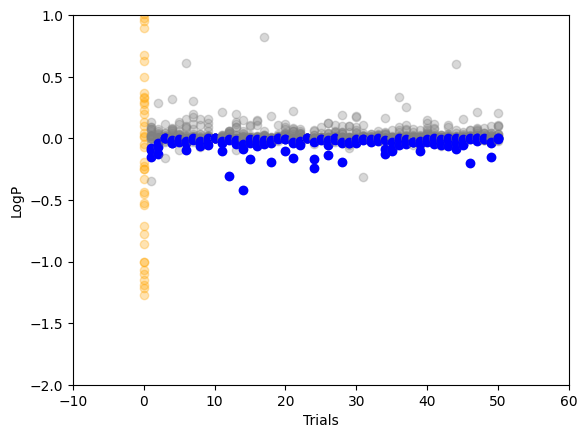

In [57]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter([0 for _ in range(50)], y_std[:50], alpha=0.3, color="orange")

for key, item in result.items():
    ax.scatter(
        [key for _ in range(n_sample_batch)], item["mean"], color="gray", alpha=0.3
    )
    ax.scatter([key for _ in range(3)], item["y_top_3"], color="blue")
ax.set_ylim(-2, 1)
ax.set_xlim(-10, 60)
ax.set_xlabel("Trials")
ax.set_ylabel("LogP")

In [76]:
z_opt = pca.inverse_transform(result[50]["X_top_3"])

In [86]:
ohe_opt = model.decode(torch.FloatTensor(z_opt))

In [87]:
ohe_opt

tensor([[[2.2370e-06, 2.0842e-07, 2.8335e-06,  ..., 6.1389e-07,
          1.2396e-07, 1.4457e-07],
         [3.1350e-09, 1.7453e-07, 1.1116e-07,  ..., 7.6251e-12,
          3.0640e-09, 5.8778e-12],
         [2.0535e-07, 7.0426e-07, 9.8771e-01,  ..., 3.2927e-09,
          1.2669e-08, 1.6320e-08],
         ...,
         [1.0000e+00, 1.1750e-11, 4.4661e-11,  ..., 1.8705e-11,
          7.4436e-10, 8.4557e-10],
         [1.0000e+00, 1.1683e-11, 4.4509e-11,  ..., 1.8694e-11,
          7.5151e-10, 8.4647e-10],
         [1.0000e+00, 1.1617e-11, 4.4362e-11,  ..., 1.8681e-11,
          7.5852e-10, 8.4725e-10]],

        [[1.6726e-06, 5.4744e-08, 5.5069e-07,  ..., 1.1518e-08,
          1.3268e-05, 7.9596e-09],
         [6.9746e-08, 8.0775e-07, 2.4687e-06,  ..., 1.7565e-09,
          1.2777e-05, 4.1685e-09],
         [3.6529e-09, 9.4282e-09, 1.9373e-07,  ..., 1.0085e-10,
          4.1167e-07, 5.5923e-12],
         ...,
         [1.0000e+00, 1.0608e-12, 2.2279e-11,  ..., 3.0887e-12,
          1.057

In [89]:
generated_smiles = [
    decode_smiles_from_one_hot(ohe.detach().cpu().numpy(), charset) for ohe in ohe_opt
]

In [94]:
generated_smiles

['CC(C)=11CCC[C@@@]]cc2c(C)[N)]2)CCN=C',
 'O[C@H](Ocnccccccc2ccnnnn1)NCCS[C@H]c2ccccc2))c1cccccccc1',
 'COCCOc1cccc((=O)c2(c3cc(C(=O)c4cccc4CC))))12']

In [95]:
!pip install rdkit

[10:18:18] SMILES Parse Error: syntax error while parsing: CC(C)=11CCC[C@@@]]cc2c(C)[N)]2)CCN=C
[10:18:18] SMILES Parse Error: Failed parsing SMILES 'CC(C)=11CCC[C@@@]]cc2c(C)[N)]2)CCN=C' for input: 'CC(C)=11CCC[C@@@]]cc2c(C)[N)]2)CCN=C'
[10:18:18] SMILES Parse Error: extra close parentheses while parsing: O[C@H](Ocnccccccc2ccnnnn1)NCCS[C@H]c2ccccc2))c1cccccccc1
[10:18:18] SMILES Parse Error: Failed parsing SMILES 'O[C@H](Ocnccccccc2ccnnnn1)NCCS[C@H]c2ccccc2))c1cccccccc1' for input: 'O[C@H](Ocnccccccc2ccnnnn1)NCCS[C@H]c2ccccc2))c1cccccccc1'
[10:18:18] SMILES Parse Error: syntax error while parsing: COCCOc1cccc((=O)c2(c3cc(C(=O)c4cccc4CC))))12
[10:18:18] SMILES Parse Error: Failed parsing SMILES 'COCCOc1cccc((=O)c2(c3cc(C(=O)c4cccc4CC))))12' for input: 'COCCOc1cccc((=O)c2(c3cc(C(=O)c4cccc4CC))))12'


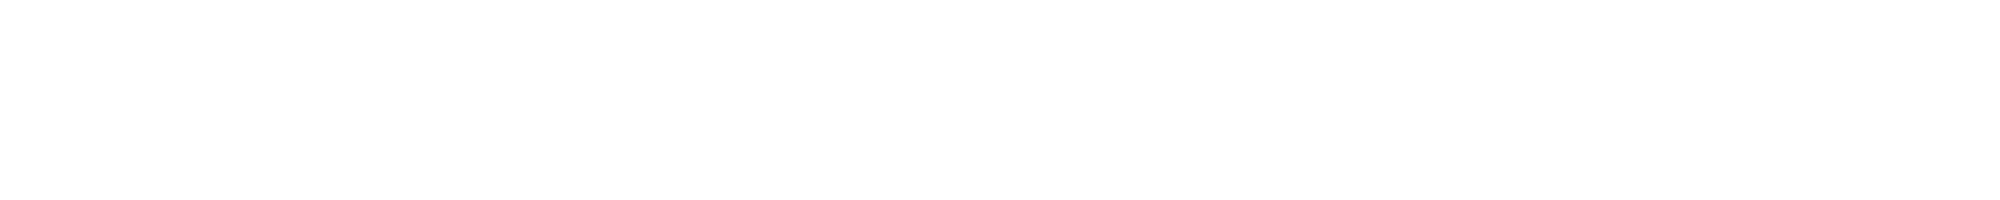

In [96]:
from rdkit import Chem
from rdkit.Chem import Draw

Draw.MolsToGridImage(
    [Chem.MolFromSmiles(smiles) for smiles in generated_smiles], molsPerRow=10
)

In [102]:
all_generated_smiles = []
for trial, res in result.items():
    z_opt = pca.inverse_transform(res["X_top_3"])
    ohe_opt = model.decode(torch.FloatTensor(z_opt))
    all_generated_smiles += [
        decode_smiles_from_one_hot(ohe.detach().cpu().numpy(), charset)
        for ohe in ohe_opt
    ]

In [107]:
valid_smiles = []
for smi in all_generated_smiles:
    if Chem.MolFromSmiles(smi) is not None:
        valid_smiles.append(smi)
    else:
        print(f"{smi} is invalid")

CC(CN(C)c1ccc(())([C@H]2C[CH+](CCCCCC=CCO1 is invalid
CC1=H](CCc2cc(CC[NH+](CCC[C@@](CCCCC()))CCC@H]C]CC1 is invalid
CCCC(=C)c1C[C@@]c(NCc2nnnn)))ccccc11 is invalid
CC[C@@H]1CCC[C@@H](c1cncc1 is invalid
C/CCHH+]c1ccc(CC=O))CC1CCC[C@]11 is invalid
COc1ccccc(NCC[C@H](C(CCCCC@]4(cc(CC(=O))CCCCCCCCCCcCCCCCC))c2)c1 is invalid
cc1cnccccccccccccccccc1 is invalid
Ccccccc2C(=S)SCCl)o1 is invalid
COc1cccc(N[C@@H]2c2[C@H](C))2)CCC)c1 is invalid
CCCC@@+]1CC[C@H](C)CC(=)))c1C(F)c1 is invalid
C=C(O))c1ccccc)n1)[C@@H](C(==(CCCCCCCCC((CCCCCCCCCCCcccccccccccc)CCC1 is invalid
CCc1ccccc1N1CC[C@H](NCCCC=O)c2ccccc2)C1 is invalid
Cc1ccccc2c2cccc(C)[C@H](CO)c3ccc(CCC())))C3)cc12 is invalid
CCc(n(C(n2ccc(C())ccnn2)))cccc2CCC((=C)2 is invalid
CC(CC)C)CCCC[C@H](S(N(N(CC((=CC(=O)C22(())cccccccccc22)C1 is invalid
Cc1ncc(C((=O)c2c(C)nnnH]c2C2CCCC[C@H]1 is invalid
CC(CO(c1ccc(C(=O)c2ccccc332)cc1C is invalid
C[NH+]1CCC@@H](Cc2ccn(C)cc22)CC1==O is invalid
O[CN+]1c(cc2cccccCl)c22ccccc1C1 is invalid
Cc1cccc(-n2c((C[nH)

[10:52:20] SMILES Parse Error: syntax error while parsing: CC(CN(C)c1ccc(())([C@H]2C[CH+](CCCCCC=CCO1
[10:52:20] SMILES Parse Error: Failed parsing SMILES 'CC(CN(C)c1ccc(())([C@H]2C[CH+](CCCCCC=CCO1' for input: 'CC(CN(C)c1ccc(())([C@H]2C[CH+](CCCCCC=CCO1'
[10:52:20] SMILES Parse Error: syntax error while parsing: CC1=H](CCc2cc(CC[NH+](CCC[C@@](CCCCC()))CCC@H]C]CC1
[10:52:20] SMILES Parse Error: Failed parsing SMILES 'CC1=H](CCc2cc(CC[NH+](CCC[C@@](CCCCC()))CCC@H]C]CC1' for input: 'CC1=H](CCc2cc(CC[NH+](CCC[C@@](CCCCC()))CCC@H]C]CC1'
[10:52:20] SMILES Parse Error: extra close parentheses while parsing: CCCC(=C)c1C[C@@]c(NCc2nnnn)))ccccc11
[10:52:20] SMILES Parse Error: Failed parsing SMILES 'CCCC(=C)c1C[C@@]c(NCc2nnnn)))ccccc11' for input: 'CCCC(=C)c1C[C@@]c(NCc2nnnn)))ccccc11'
[10:52:20] SMILES Parse Error: extra open parentheses for input: 'CC[C@@H]1CCC[C@@H](c1cncc1'
[10:52:20] SMILES Parse Error: syntax error while parsing: C/CCHH+]c1ccc(CC=O))CC1CCC[C@]11
[10:52:20] SMILES Parse Er

In [106]:
valid_smiles

[]